In [63]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
% matplotlib inline

In [175]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [278]:
exp = 2
data_file = "./data/seizure/get_50_exp_{}.mat".format(exp)
result_file = "./lkm/seizure_exp_{}.mat".format(exp)

data = sio.loadmat(data_file)

saved_result = sio.loadmat(result_file)

In [279]:
z = saved_result['Z']
t_test = saved_result['t_test']
K = saved_result['K']
K_star = saved_result['K_star']
K_star_star = saved_result['K_star_star']
noise = saved_result['noise']

In [280]:
n,k = z.shape
assert k == K.shape[0] and k == K_star.shape[0] and k == K_star_star.shape[0]

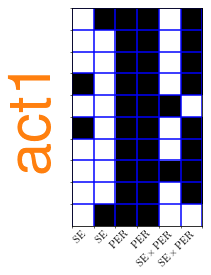

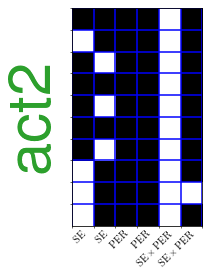

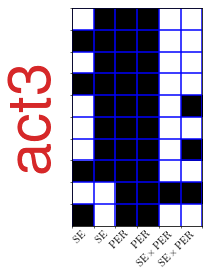

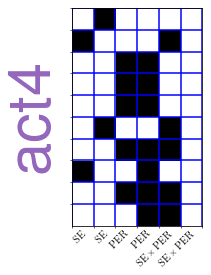

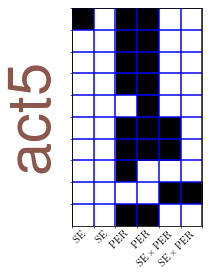

In [326]:
for i in range(5):
    fig, ax = plt.subplots()
    ax.imshow(z[10*i:10*i+10,:], interpolation='nearest', cmap='gray')
    ax.set_ylabel("act{}".format(i + 1),fontweight='bold', fontsize=60, color='C{}'.format(i+1))
    ax.grid(color='b', which='minor', linewidth=1.5)
    ax.set_xticks(np.arange(-.5, 6, 1), minor=True)
    ax.set_yticks(np.arange(-0.5,9,1), minor=True)
    ax.set_yticks([])
    ax.set_xticks(np.arange(0, 6, 1) + 0.2)
    ax.tick_params(length=0.)
    ax.set_xticklabels([r'$\textrm{SE}$',
                        r'$\textrm{SE}$', 
                        r'$\textrm{PER}$',
                        r'$\textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$'
                        ],rotation = 45, ha="right")
    fig.savefig("./data/seizure/Z/Z_{}_exp_{}.pdf".format(i,exp), dvi=300, bbox_inches='tight')

In [266]:
def plot_component_by_axes(kernels, kernel_stars, kernel_star_stars, noise, t,t_test, X, axes):
    complete_sigma = sum(kernels) + np.eye(t.shape[0])*noise
    for kernel, kernel_star, kernel_star_star, ax in zip(kernels, kernel_stars, kernel_star_stars, axes):
        temp = np.transpose(np.linalg.solve(complete_sigma, kernel_star))
        mean = np.matmul(temp, X)
        var = kernel_star_star - np.matmul(temp, kernel_star)
        data_mean = np.transpose(np.linalg.solve(complete_sigma, kernel))
        data_mean = np.matmul(data_mean, X)
        
        var = var.diagonal()
        ax.plot(t, data_mean, 'k.', lw=1)
        ax.plot(t_test, mean)
        mean = np.reshape(mean, newshape=(len(mean),1))
        var = np.reshape(var, newshape=(len(var),1))
        ax.fill_between(t_test[:,0],
                   mean[:,0] - 2*np.sqrt(var[:,0]),
                   mean[:,0] + 2*np.sqrt(var[:,0]),
                   color='C0',
                   alpha=0.2
                   )
        ax.set_xlim(np.min(t), np.max(t))
        ax.set_xticks([1., 89., 178.])

In [267]:
def plot_posterior_by_ax(kernels, kernel_stars, kernel_star_stars, noise, t,t_test, X, ax):
    complete_sigma = sum(kernels) + np.eye(t.shape[0])*noise
    sigma_star = sum(kernel_stars)
    sigma_star_star = sum(kernel_star_stars)
    temp = np.transpose(np.linalg.solve(complete_sigma, sigma_star))
    mean = np.matmul(temp, X)
    var = sigma_star_star - np.matmul(temp,sigma_star)
    var = var.diagonal()
    # print(mean.shape)
    mean = np.reshape(mean, newshape=(len(mean),1))
    var = np.reshape(var, newshape=(len(var),1))
    ax.plot(t, X, 'k.', lw=1.)
    ax.plot(t_test, mean)
    ax.fill_between(t_test[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0',
                     alpha=0.2)
    ax.set_xticks([1., 89., 178.])

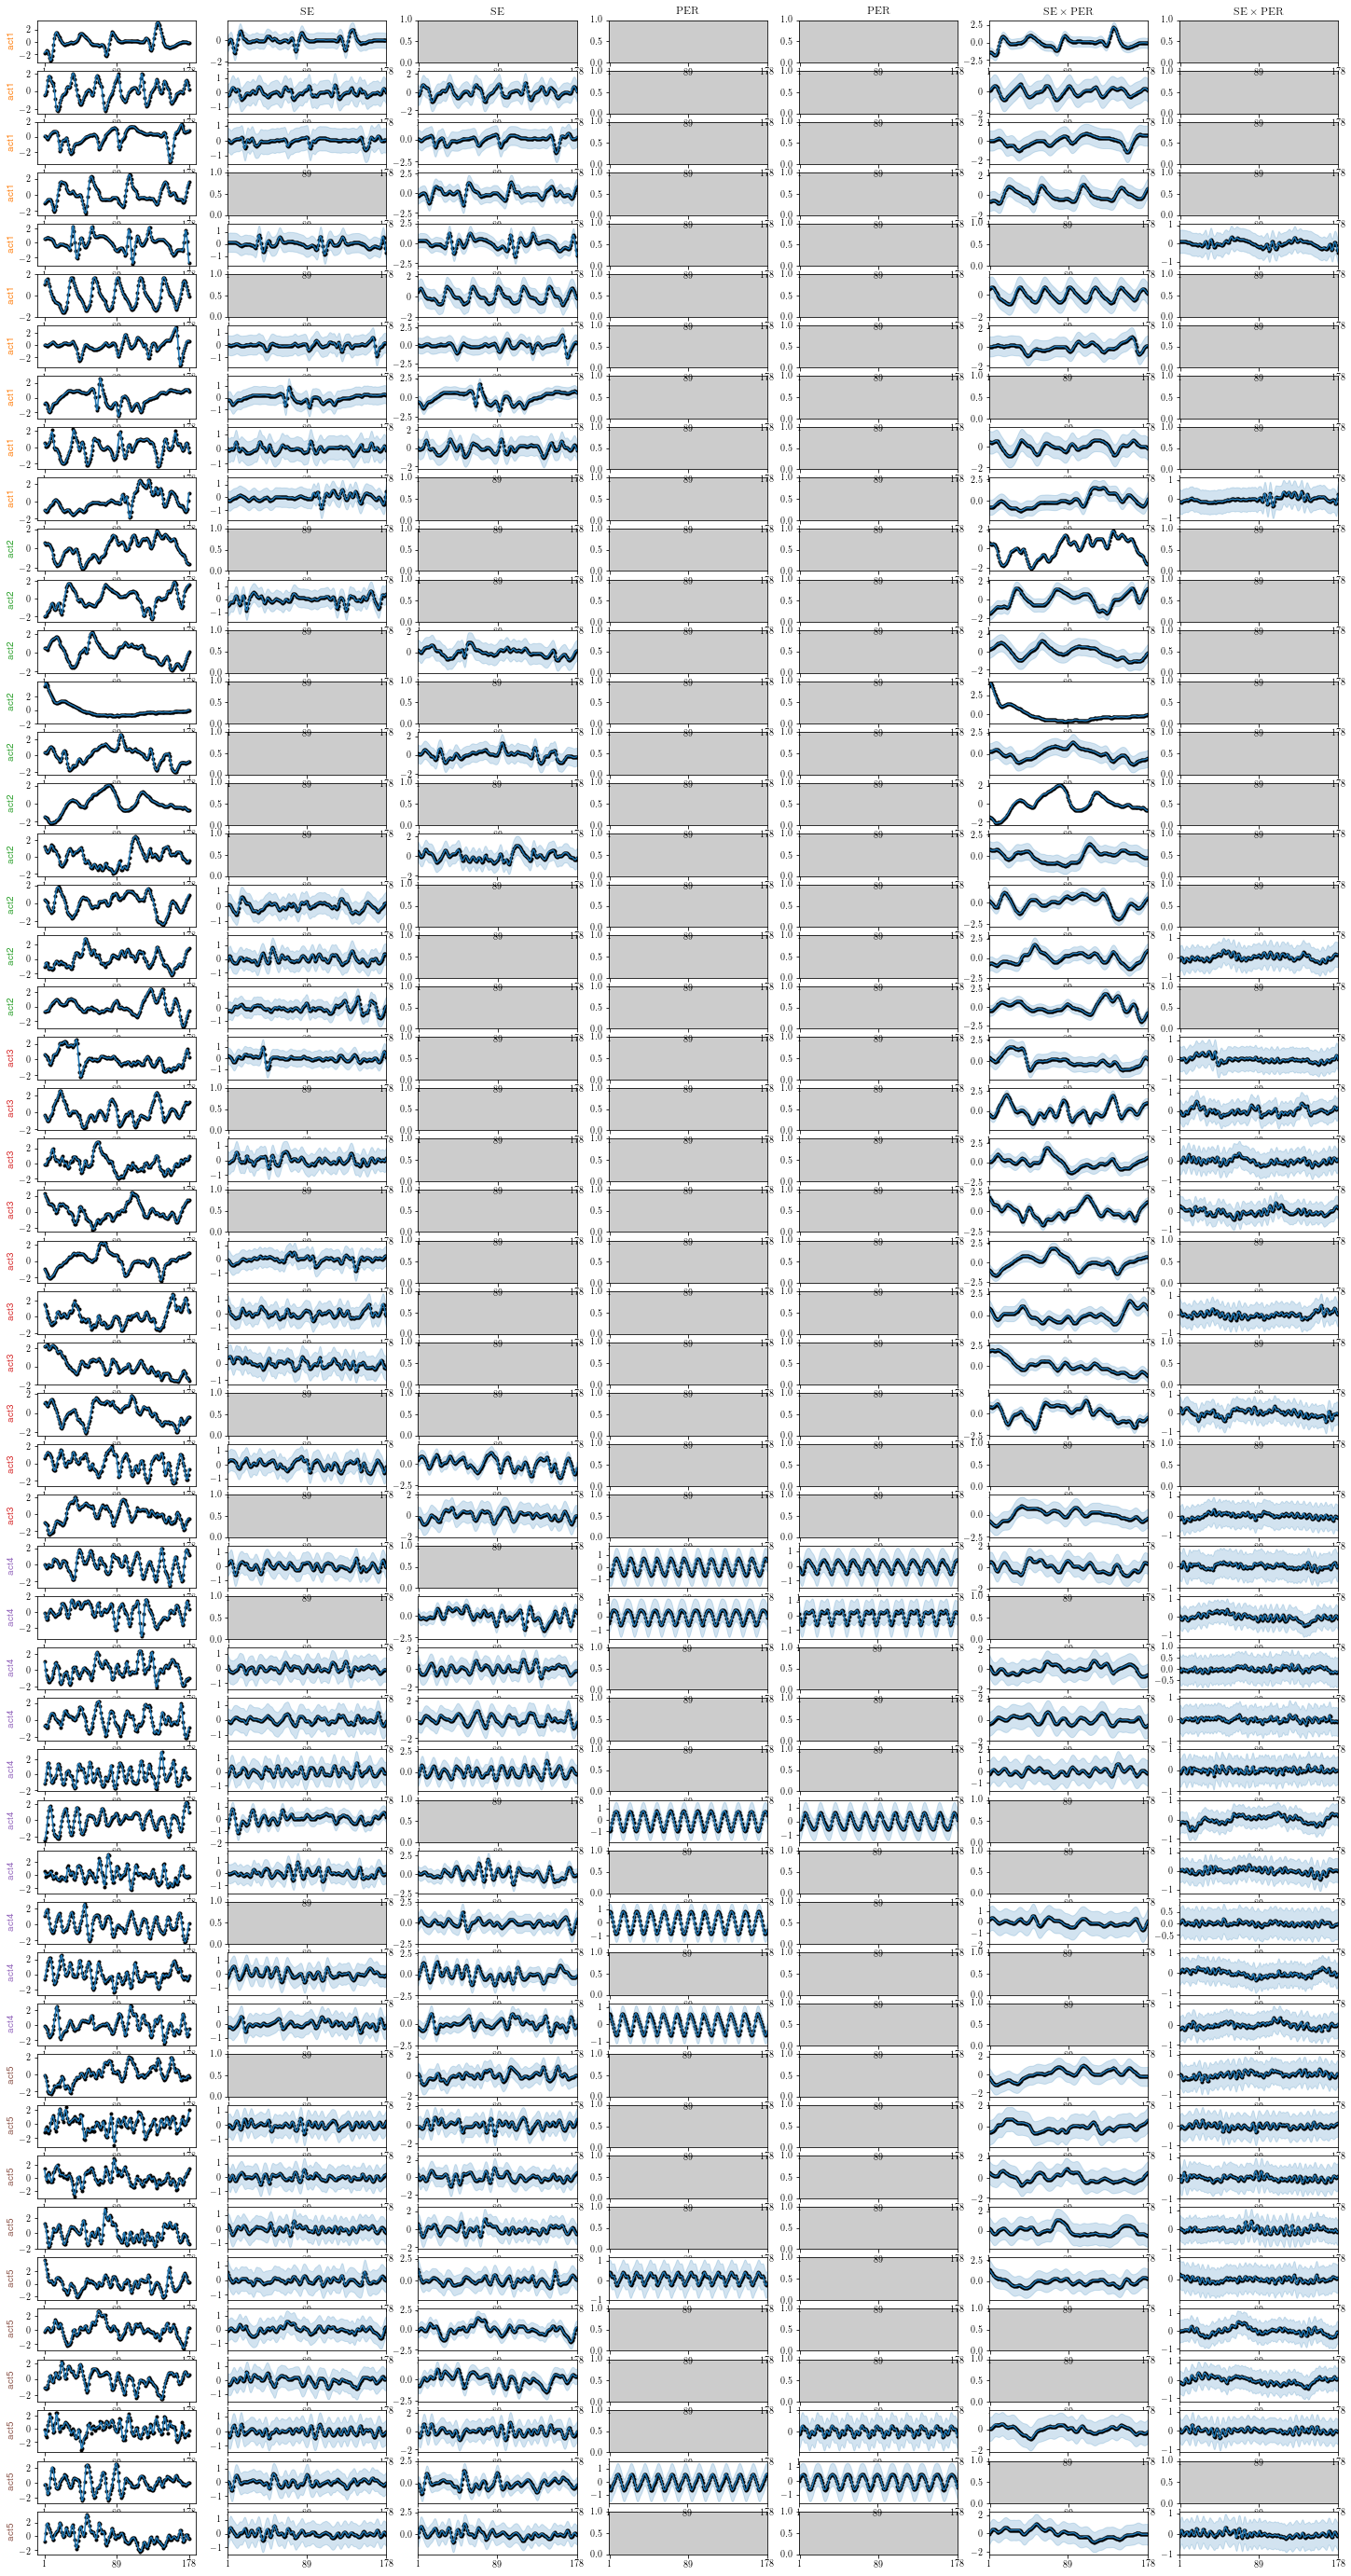

In [330]:
activities = {0:"Seizure {}",1: "Located tumor {}", 2:"Locating tumor {}", 3:"Eyes closed {}", 4:"Eyes open {}"}
kernel_names = [r'$\textrm{SE}$',
                        r'$\textrm{SE}$', 
                        r'$\textrm{PER}$',
                        r'$\textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$']
fig, axes = plt.subplots(n,k+1,figsize=(25,50))
for i in range(n):
    z_i = z[i,:]
    kernels = []
    kernel_stars = []
    kernel_star_stars = []
    input_axes = []
    for j in range(k):
        if z_i[j] == 1.:
            kernels.append(K[j,:])
            kernel_stars.append(K_star[j,:])
            kernel_star_stars.append(K_star_star[j,:])
            input_axes.append(axes[i,j+1])
            axes[i,j+1].set_xticks([1., 89., 178.])
        else:
            axes[i,j+1].set_facecolor('black')
            axes[i,j+1].patch.set_alpha(.2)
            axes[i,j+1].set_xticks([1., 89., 178.])
            
    for j, name in enumerate(kernel_names):
        axes[0,j+1].set_title(name)
    
    
    noise_variance = noise[0,i]
    X = data['X'][i,:]
    t = data['t']
    # plot_component(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X)
    plot_component_by_axes(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X, input_axes)
    plot_posterior_by_ax(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X, axes[i,0])
    activity = int(i/10)
    axes[i,0].set_ylabel("act{}".format(activity+1),fontweight='bold', fontsize=10, color='C{}'.format(activity+1))
    axes[i,0].set_yticks([-2.,0.,2.])
    
fig.savefig("./data/seizure/plot_seizure_exp_{}.pdf".format(exp), dvi=300, bbox_inches='tight')

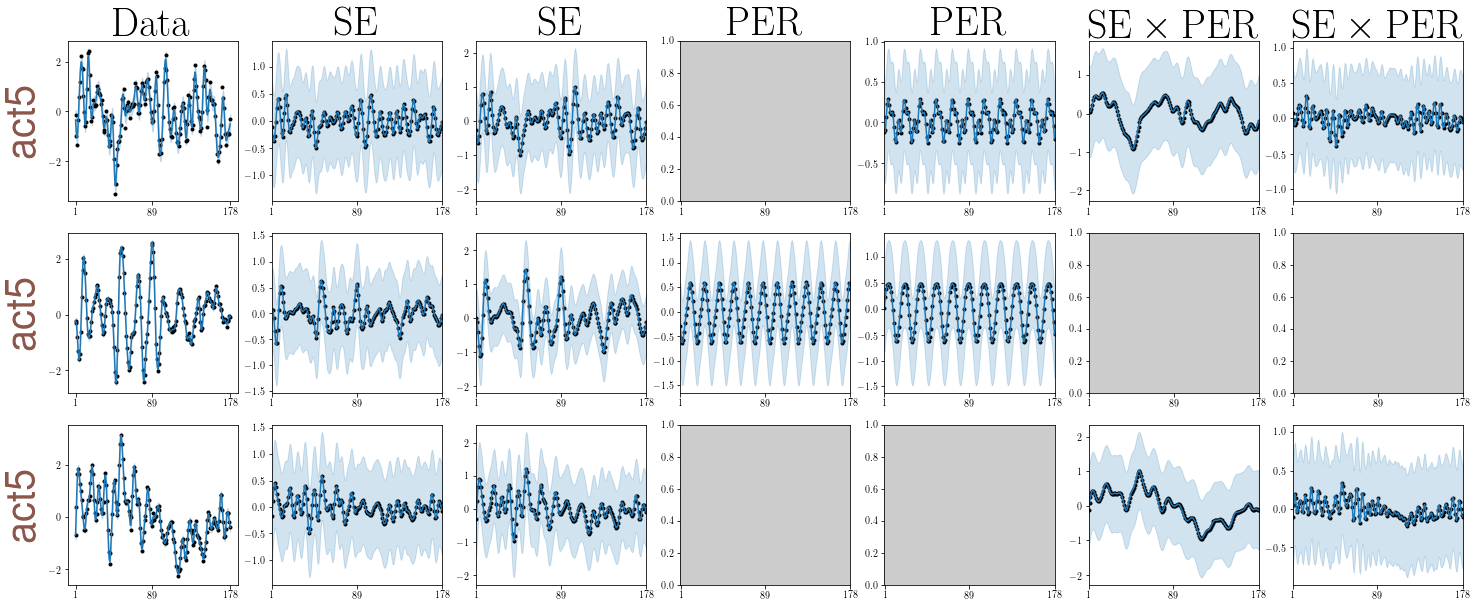

In [328]:
activities = {0:"Seizure {}",1: "Located tumor {}", 2:"Locating tumor {}", 3:"Eyes closed {}", 4:"Eyes open {}"}
kernel_names = [r'$\textrm{SE}$',
                        r'$\textrm{SE}$', 
                        r'$\textrm{PER}$',
                        r'$\textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$',
                        r'$\textrm{SE} \times \textrm{PER}$']
offset=47
length=3
fig, axes = plt.subplots(length,k+1,figsize=(25,10))
for i in range(offset,offset + length):
    axes_index = i - offset
    z_i = z[i,:]
    kernels = []
    kernel_stars = []
    kernel_star_stars = []
    input_axes = []
    for j in range(k):
        if z_i[j] == 1.:
            kernels.append(K[j,:])
            kernel_stars.append(K_star[j,:])
            kernel_star_stars.append(K_star_star[j,:])
            input_axes.append(axes[axes_index,j+1])
            axes[axes_index,j+1].set_xticks([1., 89., 178.])
        else:
            axes[axes_index,j+1].set_facecolor('black')
            axes[axes_index,j+1].patch.set_alpha(.2)
            axes[axes_index,j+1].set_xticks([1., 89., 178.])
            
    for j, name in enumerate(kernel_names):
        axes[0,j+1].set_title(name, fontdict={'fontsize':40})
    axes[0,0].set_title(r'$\textrm{Data}$', fontdict={'fontsize':40})
    
    
    noise_variance = noise[0,i]
    X = data['X'][i,:]
    t = data['t']
    # plot_component(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X)
    plot_component_by_axes(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X, input_axes)
    plot_posterior_by_ax(kernels, kernel_stars, kernel_star_stars, noise_variance, t, t_test,X, axes[axes_index,0])
    activity = int(i/10)
    axes[axes_index,0].set_ylabel("act{}".format(activity+1),fontweight='bold', fontsize=40, color='C{}'.format(activity+1))
    axes[axes_index,0].set_yticks([-2.,0.,2.])
    
fig.savefig("./data/seizure/plot_activity_{}_exp_{}.pdf".format(activity+1,exp), dvi=300, bbox_inches='tight')